In [7]:
# I appended a 0 vector for t=0 to t=48.

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Parameters
D = 500  # Dose in mg
V = 49  # Volume of distribution in L
t_half = 6  # Half-life in hours
tau = 12  # Dosing interval in hours

# Calculated parameters
#Ke = np.log(2) / t_half  # Elimination rate constant
#CL = V * k  # Clearance
#Buelga 2005
def Ke(sCr, Age, weight, V=49):
    eCCr = (140 - Age)*weight/(72*sCr)
    Vanco_CL = (60*eCCr)/(1000*1.08)# l/hr
    Kel = (Vanco_CL/V)#hr-1
    return Kel
    
    
Ke = Ke(1.3, 60, 70)  
print(Ke)
# Time array
t_max = 96  # time point when vancomycin drug admin stops
t_start = 48 #time point when drug admin begins
time = np.linspace(0, t_max, 1000)

delta_t = (t_max-t_start)/1000 #Maintain step size as in "time" variable above in case t_max and t_start are changed.
prev_time = int(48/delta_t)
prev_times = np.zeros_like(np.linspace(0,48,prev_time))

# Function to calculate concentration at any time t
def concentration(t, D, V, Ke, tau):
    conc = np.zeros_like(t)
    for i, time_point in enumerate(t):
        for n in range(int(time_point // tau) + 1):
            conc[i] += (D / V) * np.exp(-Ke * (time_point - n * tau))
    return conc

# Calculate concentration over time
conc = concentration(time, D, V, Ke, tau)
print(conc)

conc = np.concatenate((prev_times,conc)) 
print(conc.shape)

0.06783340116673449
[10.20408163 10.13778239 10.07191392 10.00647342  9.9414581   9.87686521
  9.812692    9.74893575  9.68559374  9.62266328  9.56014171  9.49802635
  9.43631459  9.37500378  9.31409133  9.25357464  9.19345116  9.13371831
  9.07437357  9.01541441  8.95683833  8.89864283  8.84082545  8.78338373
  8.72631523  8.66961752  8.61328819  8.55732485  8.50172513  8.44648665
  8.39160708  8.33708408  8.28291533  8.22909853  8.1756314   8.12251166
  8.06973706  8.01730535  7.96521431  7.91346172  7.86204538  7.81096311
  7.76021274  7.70979211  7.65969908  7.60993152  7.56048732  7.51136437
  7.46256059  7.41407391  7.36590226  7.31804359  7.27049588  7.2232571
  7.17632525  7.12969833  7.08337436  7.03735137  6.9916274   6.94620053
  6.9010688   6.85623031  6.81168315  6.76742543  6.72345526  6.67977078
  6.63637014  6.59325148  6.55041298  6.50785281  6.46556917  6.42356027
  6.3818243   6.34035951  6.29916413  6.25823641  6.21757462  6.17717701
  6.13704188  6.09716752  6.0575

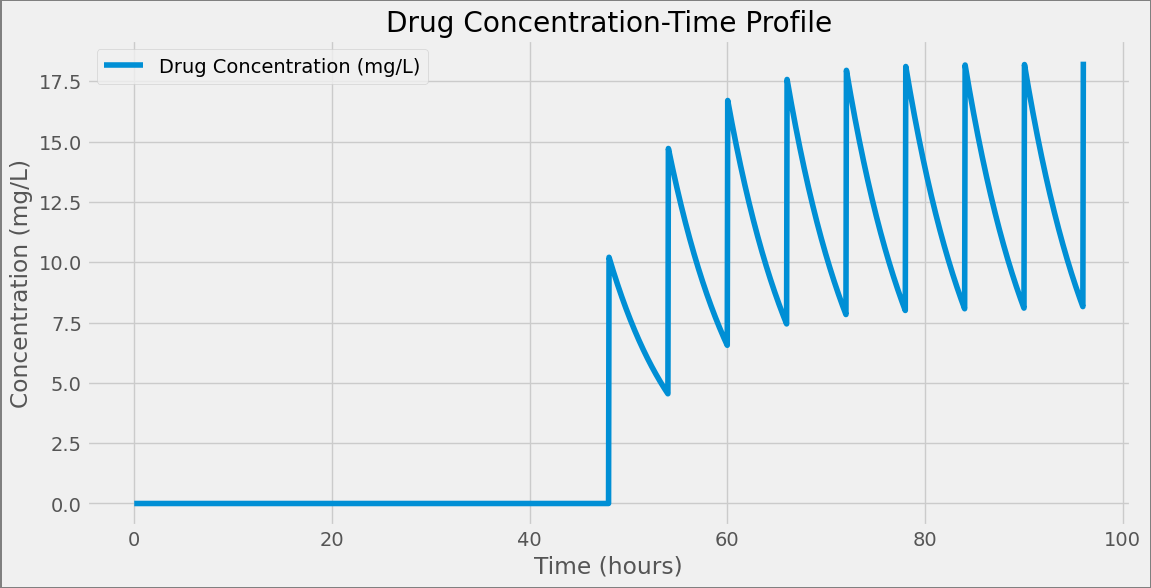

In [9]:
# Plot the concentration-time profile
#plt.rcParams['lines.linewidth'] = 1
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(12, 6), linewidth = 1.0)
ax.plot(np.linspace(0,96,2000), conc, label='Drug Concentration (mg/L)')
#ax.plot(time, conc, label='Drug Concentration (mg/L)')
ax.set_xlabel('Time (hours)')
ax.set_ylabel('Concentration (mg/L)')
ax.set_title('Drug Concentration-Time Profile')
plt.legend()
plt.grid(True)
plt.savefig("concentration-time")

In [3]:
#Staph aureus
#intrinsic growtrh rate: rho = 0.35 hour^-1
#vancomycin-induced death rate: 
#0.0958 - 0.1458, 0.1 - 0.1208
#0.166, 0.208, 0.625
#vancomycin resistant: 0.0833



# ODE system parameters
#0.6931 assuming SA doubling time of 60 minutes
#0.3466 assuming doubling time of 120 minutes
rho = 0.3466 #both sensitive and resistant SA are growing at the same rate
k = 10e5# or 10e6
#death rate for sensitive >>> death rate for resistant bacteria 
deltaS = 0.8 #death rate sensitive
deltaR = 0.0002#death rate resistant
S = 20
R = 10
r = [S, R]
EC_50 = 0.03

# System ODE
def system_ode(t, r):
    S = r[0]
    R = r[1]
    conc_t = np.interp(t, time, conc)
    dSdt = (1 - (conc_t / (conc_t + EC_50)) * rho * S*(1 - (S + R) / k)) - deltaS * S
    dRdt = rho * R * (1 - (S + R) / k) - deltaR * R
    return [dSdt, dRdt]

ode_soln = solve_ivp(system_ode, t_span=[0, t_max], y0=[2, 2], t_eval=time)







ValueError: fp and xp are not of the same length.

NameError: name 'ode_soln' is not defined

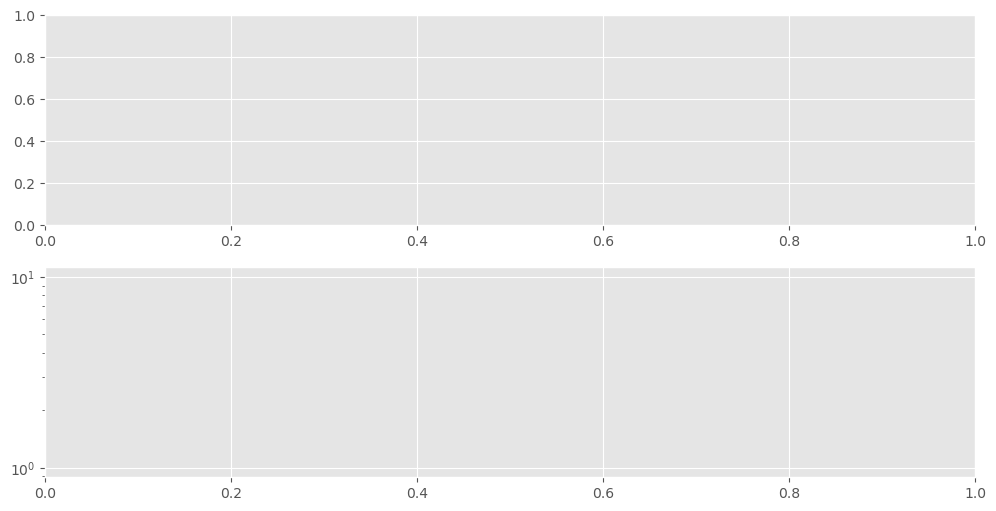

In [5]:
# Plot the ODE solution
plt.rcParams['lines.linewidth'] = 1
plt.style.use('ggplot')
fig, ax = plt.subplots(2, figsize=(12, 6))

plt.yscale("log")
ax[0].plot(ode_soln.t, ode_soln.y[0], label='S')
ax[1].plot(ode_soln.t, ode_soln.y[1], label='R')
ax[0].set_xlabel('Time (hours)')
ax[0].set_ylabel('Population (log)')
ax[1].set_xlabel('Time (hours)')
ax[1].set_ylabel('Population (log)')
ax[0].set_title('Evolution of sensitive bacteria (death rate 0.8)')
ax[1].set_title('Evolution of resistant bacteria (death rate 0.0002)')
fig.subplots_adjust(hspace= 0.5, wspace=0.2)  # Adjust horizontal space between plots
plt.legend()
plt.grid(True)
plt.savefig('2024-08-27Resistant0.0002.png')

## Calculating model parameters for vancomycin

In [11]:
def Ke(sCr, Age, weight, V=49):
    eCCr = (140 - Age)*weight/(72*sCr)# ml/min
    Vanco_CL = (60*eCCr)/(1000*1.08)# l/hr
    Kel = (Vanco_CL)/(V)# hr-1
    return Kel
    
    
Ke = Ke(1.3, 60, 70)  
print(Ke)

0.06783340116673449


In [12]:
eCCr = (140 - 60)*70/(72*1.2)#mL/min
print(eCCr)

64.81481481481482


## Vancomycin CL from Buelga 2005

In [13]:
Vanco_CL = (60*eCCr)/(1000*1.08)# l/hr
print(Vanco_CL)

3.6008230452674903


In [14]:
t_half = 6  # Half-life in hours
#tau = 12  # Dosing interval in hours

# Calculated parameters
Ke = np.log(2) / t_half  # Elimination rate constant
new_Ke = Ke
print(new_Ke)

0.11552453009332421


In [15]:
Ke = 0.00083*eCCr + 0.0044
Ke

0.05819629629629631